# Product Recognition on Store Shelves

**Marco Scaramuzzi** 

- Student ID: 0001057167
- email: marco.scaramuzzi@studio.unibo.it

## Task - Step A - Multiple Product Detection

Develop a computer vision system that, given a reference image for each product, is able to identify boxes of cereals of different brands from one picture of a store shelf. For each type of product displayed in the shelf the system should report:

1. Number of instances.
2. Dimension of each instance (width and height of the bounding box that enclose them in pixel).

#### Test on scene image: {e1.png, e2.png, e3.png, e4.png, e5.png} 
#### Use product images: {0.jpg, 1.jpg, 11.jpg, 19.jpg, 24.jpg, 26.jpg, 25.jpg} 

**Disclaimer**

In order to provide ease of access and at the same time having a modular project structure only the **relevant** functions were left inside the notebook, others utility functions such as displaying images or drawing bounding boxes are put inside the `image_utils.py` and the `bounding_box.py` files which are located in the `/utils` folder, if there is a need inspect their contents.

In [197]:
#Import required modules

import numpy as np
import cv2
import os
from glob import glob

# Visualization
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# Type annotations
from numpy.typing import NDArray
from typing import Callable, Dict, List, Tuple

# Custom modules
import utils.image_utils as iut
import utils.bounding_box_utils as bb

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Organisation and structure of the notebook

This notebook attemps at solving the `step_A`   of the Product recognition on store shelves. In this step the task consist on correctly detecting the presence of a certain brand cereal box in a shelve inside a supermarket. 

- In this first step the problem is posed as a single instance detection, that means for each brand there is at most a single box. Therefore I will exploit the `Local Invariant Features` which were analyzed in the Laboratory 5. 

- I utilized SIFT to detect and describe keypoints in the images, employed a k-nearest neighbors (k-NN) search using the FLANN-based matcher for feature matching.
- To compute a robust homography i employed the RANSAC algorithm , which enables accurate localization of the detected objects within the scene.

- Given that the problem at hand is **single instance** `Local Invariant Features` and a **rescaling** of the images were enough to reach a **satisfiable** result. The rescaling was used in order to avoid issues in the search for model instances in the scenes. 

The notebook is structured in six sections:

1. **Data inspection**: In this section there will be a brief assessment what type of data we are dealing with.
2. **Keypoints detection**: In this section By using SIFT descriptors keypoints will be detected in both the scene images and the model images.
3. **Feature matching**: In this section By using FLANN match i will attemp to find a matches by corresponding keypoints between scene and models.
   
4. **Object identification**:  In this section the matches will be filtered in order to keep only true matches between model images and  scene images.
5. **Displaying bounding boxes and printing matching coordinates**: In this section all the code from the previous sections will be employed to draw bounding boxes for the matched models and printing their dimensions.
6. **Results computations**: This section will display the results and draw some brief conclusions upon those results. 



## 1. Data inspection

#### Loading and inspecting images

In the cell below we can see the parameter `target_model_dims`, it is a tuple containing the new size that all  that **all** models will have after an operation of resizing. This has been done because the models have different shapes, therefore the function that loads the images will resize the image to a predetermined size if the images are models. This allows to avoid inconsistencies in the detection of the keypoints.

In [198]:
MODEL_REFERENCE_NUM = [0,1,11,19,24,25,26] # defining enviromental variable containing the model reference numbers

In next i will load only greyscale model image, Given that SIFT works natively with greyscale images.

model: 0 | original_height = 1500 | original_width = 1105
model: 1 | original_height = 1500 | original_width = 1146
model: 11 | original_height = 238 | original_width = 161
model: 19 | original_height = 483 | original_width = 354
model: 24 | original_height = 387 | original_width = 270
model: 25 | original_height = 798 | original_width = 595
model: 26 | original_height = 394 | original_width = 284


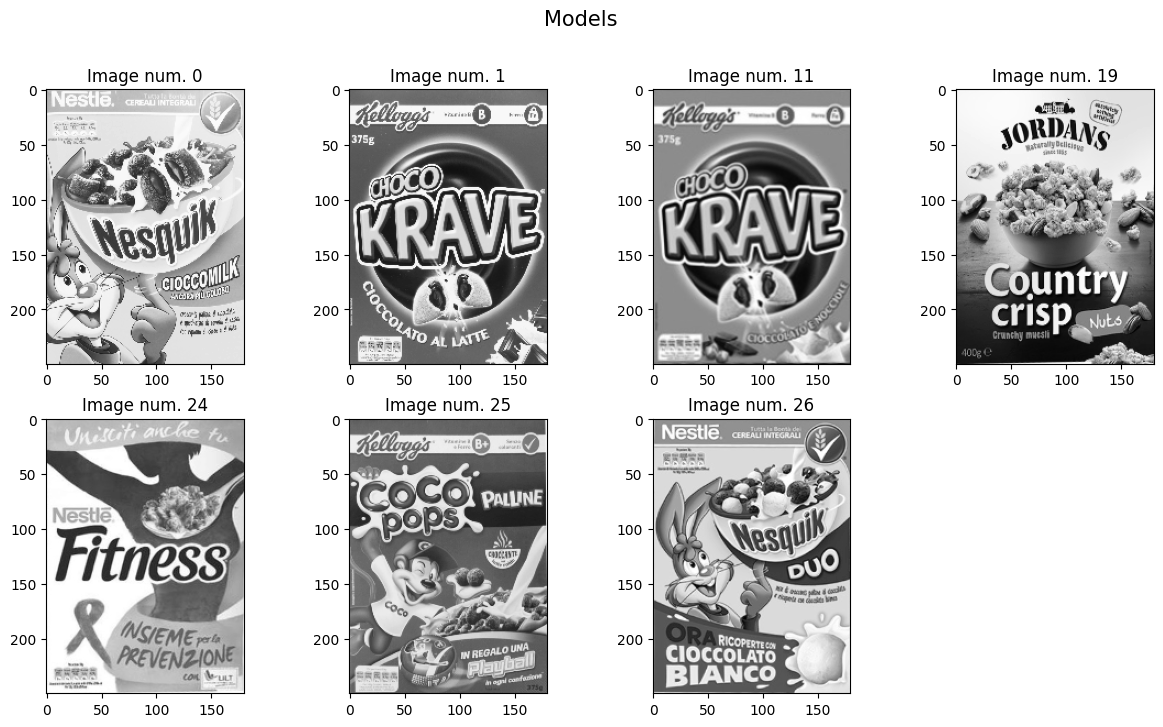

In [213]:
# Load grayscale resized model images for SIFT processing, which is designed for grayscale images.
_ , query_images_grey = iut.load_images(
                            base_path='models',
                            step_directory='step_A',
                            image_indices=MODEL_REFERENCE_NUM,
                            is_resized=True, target_model_dims=(180, 250))

iut.show_images(query_images_grey, n_cols=4, title='Models')

By looking at the original images shapes we can see a disparity between some of the models.

This issue arises from the fact that the models were acquired or provided at very different sizes. Such disparity can lead to poor or unstable matches, since the size of the objects influences both the density and the scale of the extracted features.

Although SIFT (Scale-Invariant Feature Transform) is theoretically scale-invariant, in practice, a large size disparity can negatively impact the accuracy of feature matching. Therefore, it is good practice to resize all models to the same dimensions before applying SIFT, in order to ensure more reliable and balanced descriptor extraction when matching them against the scene.

#### Loading scene images inspecting them

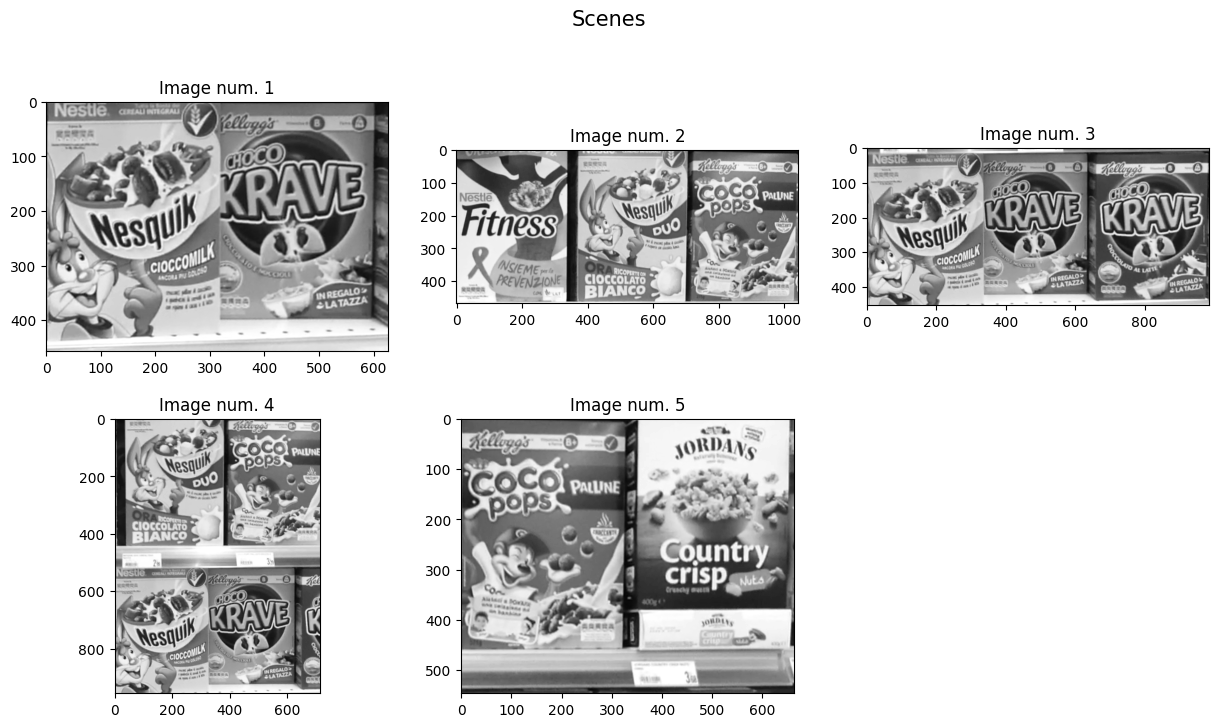

In [200]:
# Load scene images for step_A
train_images_rgb, train_images_grey = iut.load_images(base_path='scenes', step_directory='step_A')
iut.show_images(train_images_grey, n_cols=3, title='Scenes')

The disparity for the scenes is not so visible, but we can see that the scenes number 2 and 3 are a bit larger than the others and that the scene 4 is a bit higher than the others (it depicts two shelves).

## 2. Keypoints detection and description

In this section of the notebook we will define how the image keypoints and their descriptors will be handled:

1. In the **section 2.1** I will define the functions that will allow to detect keypoints and their descriptor for each model/scene.

### 2.1 Keypoint detection for each model


The  `extract_features_dict`  returns a tuple containing two dictionaries: one storing all the keypoints and the other storing the descriptors. The keys for theese dictionaries are the model/scenes indexes. 

- Example output:
    ```python

    MODEL_INDEXES = [0,1,11,19,24,25,26]

    keypoints_dict = {
            model_indexes[0]: [<cv2.KeyPoint 0x1>, <cv2.KeyPoint 0x2>],
            model_indexes[1]: [<cv2.KeyPoint 0x7>, <cv2.KeyPoint 0x8>],
            # ... more keys for each image id
    }
    
    descriptors_dict = {
            scene_indexes[0]: np.array([[ 1.,  2.,  3.], [ 4.,  5.,  6.]], dtype=np.float32),
            scene_indexes[1]: np.array([[ 7.,  8.,  9.], [10., 11., 12.]], dtype=np.float32),
            # ... more keys for each image id
    }

    SCENE_INDEXES = [1,2,3,4,5]

    keypoints_dict = {
            scene_indexes[1]: [<cv2.KeyPoint 0x1>, <cv2.KeyPoint 0x2>],
            scene_indexes[2]: [<cv2.KeyPoint 0x7>, <cv2.KeyPoint 0x8>],
            # ... more keys for each image id
    }
    
    descriptors_dict = {
            model_indexes[1]: np.array([[ 1.,  2.,  3.], [ 4.,  5.,  6.]], dtype=np.float32),
            model_indexes[2]: np.array([[ 7.,  8.,  9.], [10., 11., 12.]], dtype=np.float32),
            # ... more keys for each image id
    }
    ```

In [ ]:
def extract_features_dict(
    images: dict[int, NDArray[np.uint8]],
    detector: cv2.Feature2D ) -> tuple[dict[int, list[cv2.KeyPoint]],
                dict[int, NDArray[np.float32]]]:

    """
    Extract keypoints and descriptors for each image using a feature detector.

    This function processes a collection of images, extracting feature keypoints
    and descriptors for each image using a specified OpenCV feature detector
    (e.g., SIFT, ORB). The extracted features are organized into dictionaries
    for easy access and analysis.

    Args:
        images (dict[int, NDArray[np.uint8]]):
            A dictionary where the keys are image IDs (integers) and the values
            are the corresponding images represented as NumPy arrays in uint8 format.

        detector (cv2.Feature2D):
            An OpenCV Feature2D object responsible for detecting keypoints and
            computing descriptors (e.g., cv2.SIFT_create()).

    Returns:
        tuple[dict[int, list[cv2.KeyPoint]], dict[int, NDArray[np.float32]]]:
            A tuple containing two dictionaries:
            - keypoints_dict: A dictionary mapping each image ID to a list of keypoints.
            - descriptors_dict: A dictionary mapping each image ID to its descriptors.

    Example:
        images = {
            1: cv2.imread("image1.jpg"),
            2: cv2.imread("image2.jpg")
        }
        detector = cv2.SIFT_create()
        keypoints_dict, descriptors_dict = extract_features_dict(images, detector)

    Notes:
        - The function assumes that the input images are in grayscale or RGB format.
    """

    kp_dict = {}
    des_dict = {}

    for img_id, img in images.items():
        kp_grey, des_grey = detector.detectAndCompute(img, None)
        kp_dict[img_id] = kp_grey
        des_dict[img_id] = des_grey

    return kp_dict, des_dict

The structure of the keypoints and descriptors dictionary is shown for clarity, but it will be re-computed inside the functions that will perform feature matching.

In [202]:
# Instantiate dictionaries containing keypoints for query and train images
sift = cv2.SIFT_create()
kp_query_dict, des_query_dict = extract_features_dict(query_images_grey, sift)
kp_train_dict, des_train_dict = extract_features_dict(train_images_grey, sift)

In [247]:
# The dictionaries keys are the model/scene number
# and they contain the keypoints/descriptors as values
print('\n- Model number keys: ', kp_query_dict.keys())
print('\n- Inspecting that the key structure is correct for model 0 keypoints: \n',
        kp_query_dict[0][:3])


- Model number keys:  dict_keys([0, 1, 11, 19, 24, 25, 26])

- Inspecting that the key structure is correct for model 0 keypoints: 
 (< cv2.KeyPoint 0000013109DD66A0>, < cv2.KeyPoint 00000131189836C0>, < cv2.KeyPoint 0000013110D161F0>)


In [238]:
# Same for descriptors
print('\n- Scene number number keys: ', des_train_dict.keys())

print('\n- Inspecting that the values structure is correct for scene 1: ',
        list(des_train_dict.values())[:2])


- Scene number number keys:  dict_keys([1, 2, 3, 4, 5])

- Inspecting that the values structure is correct for scene 1:  [array([[164.,  19.,   4., ...,   0.,   0.,   0.],
       [  2.,   4.,   2., ...,  94.,   4.,   0.],
       [  3.,   3.,   0., ...,   0.,   0.,   0.],
       ...,
       [  3.,   0.,   0., ...,   0.,   0.,   0.],
       [ 77.,   2.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0., 117.]], dtype=float32), array([[ 7.,  0.,  0., ...,  0.,  0.,  0.],
       [11.,  2.,  0., ..., 30., 78.,  6.],
       [49.,  2.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  9.,  7.,  4.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ..., 54.,  4., 27.]], dtype=float32)]


## 3. Feature matching

In this section I will attempt to find instances of the model images across the various scene images. 

1. The first step to achieve this is to instantiate the matching criterion. This will be achieved using an approximate but effective matcher: FLANN, which will be instantiated through the function `initialize_flann`.

2. Given that the problem is single instance we can employ the **Lowe** criterion,  which allows discarding incorrect matches by assuming that a match for a keypoint (**m**) is good if, the distance from m of the second best match (**n**), is greater than a certain value. This logic of filtering matches will be implemented by the function `filter_matches`.

4. This filtering function will be used inside `compute_matches` which will return the matches that resepect the Lowe criterion for all the three color channels.

In [ ]:
def initialize_flann():
    """
    Initializes the FLANN matcher with default parameters.

    Returns:
        cv2.FlannBasedMatcher: Instance of the FLANN Matcher.
    """

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    return cv2.FlannBasedMatcher(index_params, search_params)

In [ ]:
def filter_matches(matches: list[list[cv2.DMatch]]) -> list[cv2.DMatch]:

    """
    Filters false positives using Lowe's ratio test.

    This function accepts a match only if:
        - The distance of the best match (m) is significantly smaller than
        the distance of the second-best match (n).
        - Specifically, m.distance < 0.7 * n.distance.

    Parameters:
        matches (list[list[cv2.DMatch]]): List of pairs (k=2)
        obtained from knnMatch(..., k=2).

    Returns:
        list[cv2.DMatch]: List of accepted matches that pass the ratio test.
    """

    # Ratio threshold for filtering matches
    # (increased from 0.7 to 0.8 for less stricter filtering)
    lowe_ratio = 0.8
    good_matches = []
    for m, n in matches:
        if m.distance < lowe_ratio * n.distance:
            good_matches.append(m)
    return good_matches

In [239]:
def compute_matches(
    des_query: NDArray[np.float32],
    des_train: NDArray[np.float32],
    flann_init_func: Callable[[], cv2.FlannBasedMatcher],
    filter_func: Callable[[List[List[cv2.DMatch]]], List[cv2.DMatch]]
    ) -> List[cv2.DMatch]:

    """
    Performs matching (k=2) and filtering (ratio test) between the descriptors
    of the 'model_id' and those of the 'scene_id'.

    Returns a dictionary:
        Containing the "good" matches as per the Lowe's ratio.

    Parameters:
        des_query (NDArray[np.float32): Descriptors of the query image (model).
        des_train: (NDArray[np.float32]): Descriptors of the train image (scene).
        flann_init_func (Callable): Function that creates and returns a new FLANNBasedMatcher.
        filter_func (Callable): Function that filters the k=2 matches (e.g., ratio test).

    Returns:
        good_matches List[cv2.DMatch]:
        A list of cv2.DMatch objects representing the "good" matches
    """

    # Initialize the FLANN matcher.
    flann_matcher = flann_init_func()

    # Perform knnMatch with k=2.
    matches = flann_matcher.knnMatch(des_query, des_train, k=2)

    # Apply the ratio test or other filtering.
    good_matches = filter_func(matches)

    return good_matches

## 4. Object identification

In this section I will attempt at finally identifying the model boxes inside the scenes.

1. First I will stack the coordinates of the good matches from the the three channels into a single array and then compute the homography by exploiting the RANSAC algorithm provided by `opencv`. This is implemented in the `compute_homography` function. 
   1. This function takes as input the keypoints found in the query and train images and the matches obtained with the `compute_matches` function and returns the homography calculated using the `findHomography` function of OpenCV (which uses RANSAC to obtain a robust homography).
   
2. I will combine the functions we defined in the previous sections of this notebook and the data structures that were described. In particular the function `object_retrieve` will: 
   1. Take the descriptors and keypoints arrays obtained from the function `compute_matches` and from those it will check with a criterion if the number of good matches is enough to identify a model in a scene, so it will determine if the number of keypoints matches are enough to determine that the instance of a model is found in the scene.  
   
   2. If the number of matches exceeds the criterion for establishing a match, then the homography and the perspective transformation of the model's corners to scene are computed. 
   3. The number of matches will be an input to the main function that will actually compute the whole computer vision pipeline. The value of the number of matches has been tuned in order to solve the task.


In [ ]:
def compute_homography(
    kp_query: List[cv2.KeyPoint],
    kp_train: List[cv2.KeyPoint],
    good_matches: List[cv2.DMatch]
) -> NDArray[np.float64]:
    """
    Compute a robust homography matrix that maps points from the query image
    to the train image using matched keypoints.

    Args:
        kp_query (List[cv2.KeyPoint]): Keypoints for the query image.
        kp_train (List[cv2.KeyPoint]): Keypoints for the train image.
        good_matches (List[cv2.DMatch]): Filtered good matches.

    Returns:
        NDArray[np.float64]: A 3x3 homography matrix computed using RANSAC.
    """

    src_pts = np.float32([kp_query[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_train[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return M


In [ ]:
def object_retrieve(
    flann_init_func: Callable[[], cv2.FlannBasedMatcher],
    filter_func: Callable[[List[List[cv2.DMatch]]], List[cv2.DMatch]],
    img_query: NDArray[np.uint8],
    kp_query: tuple[cv2.KeyPoint],
    des_query: NDArray[np.float32],
    kp_train: tuple[cv2.KeyPoint],
    des_train: NDArray[np.float32],
    min_match_count: int
) -> NDArray[np.float32] | None:
    """
    Locates a query object within a train image using feature matching and homography estimation.

    This function identifies potential instances of a query object (e.g., a product box) within a train image
    (e.g., a store shelf). It leverages feature matching between the query and train images to find corresponding
    keypoints, and then uses these matches to estimate a homography matrix. This matrix is used to project the
    query image's corners onto the train image, effectively outlining the object's location.

    Args:
        flann_init_func (Callable[[], cv2.FlannBasedMatcher]):
            A function that initializes and returns a cv2.FlannBasedMatcher object.

        filter_func (Callable[[List[List[cv2.DMatch]]], List[cv2.DMatch]]):
            A function that filters a list of raw matches (cv2.DMatch objects)
            and returns a refined list of good matches.

        img_query (NDArray[np.uint8]):
            The query image, which contains the object to be located.

        kp_query (tuple[cv2.KeyPoint]):
            A tuple of keypoints detected in the query image.

        des_query (NDArray[np.float32]):
            A NumPy array containing the descriptors for the keypoints in the query image.

        kp_train (tuple[cv2.KeyPoint]):
            A tuple of keypoints detected in the train image.

        des_train (NDArray[np.float32]):
            A NumPy array containing the descriptors for the keypoints in the train image.

        min_match_count (int):
            The minimum number of good matches required to consider the object
            as successfully detected.
            This threshold helps to prevent false positives by ensuring that there are
            enough reliable matches between the query and train images.

Returns:
        NDArray[np.float32] | None:
            If the object is successfully detected (i.e., sufficient good matches are found),
            this function returns a NumPy array containing the coordinates of the projected
            corners of the query image in the train image. These corners define a
            quadrilateral that outlines the location of the object. If the object is
            not detected, the function returns None.
    """

    # 1. Retrieve matches
    good_matches = compute_matches(
        des_query,
        des_train,
        flann_init_func,
        filter_func)

    # Count the total number of matches across all channels
    num_matches = len(good_matches)

    # 2. If number of matches exceeds the threshold, compute the homography
    if num_matches > min_match_count:
        homography = compute_homography(
            kp_query,
            kp_train,
            good_matches)

        height, width = img_query.shape[:2]

        # Corners of the query image (model)
        pts = np.float32([
            [0, 0],             # top-left corner
            [0, height - 1],    # bottom-left corner
            [width - 1, height - 1],  # bottom-right corner
            [width - 1, 0]      # top-right corner
        ]).reshape(-1, 1, 2)

        # Projecting the corners into the train image
        dst = cv2.perspectiveTransform(pts, homography)
        return dst

    # Return None if no valid matches are found
    else:
        return None

## 5. Displaying bounding boxes and printing matching coordinates

In this section I will deal with the computation of the bounding box and of the coordinates of found boxes, putting together all the functions developed until this section of the notebook. 

1. Before the main function it is defined an utility function that is important because it encapsulates the printing of center coordinates and dimension of the found boxes. It takes as input the box features that will be computed inside the `main` function and the query and train images in order to correctly display the output and it returns the scene image with the all the bounding boxes drawn for the query images instances found inside the train images. 

2. The `main` function will make use of all the other components that were defined in this notebook:

   - It works by performing a loop first on all the scenes and then checking for each scene, if the model that has been selected is present in the said scene. If the model is found as per the criteria defined in the notebook the bounding box will be drawn and the code will print the requested output as per the project specification.

   - An important thing to note is the usage of the function `compute_aligned_rectangle` that is defined in the module **`bounding_box_utils`**.  This function approximates the detected object's bounding box with a rectangle to compute its center and dimensions (width and height). It accepts the points of the bounding box (obtained via the computed homography) and returns the rectangle's vertices, its width, height, and center. 
     - It is important because it defines limits for the position of the bounding box's points. If not constrained, they can exceed the image borders and also the polyline that connects them is not a rectangle. Therefore it also ensures the rectangular shape of the bounding box, especially for the choco pops model which would often time be skewed and not be a closed shape.

   - The instructions are interleaved with some utility code to make it more distinguishible which scene is being currently analyzed

   - Lastly the function will display the required information for the position of the centers of the boxes and their dimensions, it will draw the bounding box and, at the center of each model found in the scene, it will display the number of the found model.

In [210]:
def process_and_draw_instances(boxes_info: list, query_images: dict[str, np.ndarray],
                            img_train_rgb: np.ndarray) -> np.ndarray:
    """
    Process and draw bounding boxes for detected instances in the train image.

    Args:
        boxes_info (list): List of detected instances information.
        query_images (dict): Dictionary of query images.
        img_train (np.ndarray): Train image to draw bounding boxes on.

    Returns:
        np.ndarray: The train image with drawn bounding boxes.
    """

    # Draw on a copy to preserve the original image
    img_train_bounding = img_train_rgb.copy()

    for instances_single_model, query_name in zip(boxes_info, query_images.keys()):
        num_instance = 0
        found_instances = len(instances_single_model)
        print(f"Product {query_name} - {found_instances} instance(s) found:")

        for instance_info in instances_single_model:
            # Extract box info (rectangle, box_width, box_height, box_center)
            rectangle = instance_info[0]
            box_width = instance_info[1]
            box_height = instance_info[2]
            box_center = instance_info[3]

            # Draw the rectangle on the image
            img_train_bounding = cv2.polylines(
                img_train_bounding,
                pts=[np.int32(rectangle)],
                isClosed=True,
                color=(0, 255, 0),
                thickness=4,
                lineType=cv2.LINE_AA
            )

            # Place the product number at the center using the helper function
            text_str = str(query_name)

            img_train_bounding = bb.draw_text_with_background(
                img_train_bounding,
                text_str,
                box_center,
                font=cv2.FONT_HERSHEY_SIMPLEX,
                font_scale=2.75,
                thickness=8,
                bg_color=(255, 255, 255),
                opacity=0.5,
                text_color=(0, 220, 0) # more readable shade of green
            )

            num_instance += 1

            print(f"\tInstance {num_instance} {{position: ({box_center[0]}, {box_center[1]}), width: {box_width}px, height: {box_height}px}}")

    print()
    return img_train_bounding


In [211]:
def main(min_count: int, query_images_grey: dict[int, np.ndarray],
        train_images_rgb: dict[int, np.ndarray],
        train_images_grey: dict[int, np.ndarray],
        height_threshold : float = 1.5,
        ) -> None:
    """
    Iterate over each scene and model to perform object detection and compute bounding boxes.

    This function extracts features from both the query (model) and train (scene) images, then for each scene,
    it matches each model against the scene using the object_retrieve function. If a match is successful based on
    the minimum match threshold (min_count per channel), it collects positional information of the current detected model in the scene.
    Finally, it draws bounding boxes on the train image and displays the results.

    Args:
        min_count (int): Minimum number of matches required per channel to consider a valid detection.
        query_images (dict[int, np.ndarray]): Dictionary mapping model identifiers to their corresponding
            query image arrays.
        train_images (dict[int, np.ndarray]): Dictionary mapping scene identifiers to their corresponding
            train image arrays.

    Returns:
        None
    """

    # Extract features for query and train images
    kp_query_dict , des_query_dict = extract_features_dict(query_images_grey, sift)
    kp_train_dict , des_train_dict = extract_features_dict(train_images_grey, sift)

    separator = '*****'

    for scene_id in train_images_rgb.keys():

        boxes_info = []  # List of lists of tuples: (box_center, box_width, box_height, dst)
        print(f'🖼️ Analysis of scene: {scene_id}\n')
        print(f"{separator*20}\n")

        img_train_rgb = train_images_rgb[scene_id]

        kp_train = kp_train_dict[scene_id]
        des_train = des_train_dict[scene_id]

        for model_id in query_images_grey.keys():

            # Contains spatial informations for all the instances of the current model found in the scene
            instances_single_model = []

            img_query = query_images_grey[model_id]

            kp_query = kp_query_dict[model_id]
            des_query = des_query_dict[model_id]

            # Attempt to retrieve the object (returns transformed corner points if found)
            dst = object_retrieve(
                initialize_flann,
                filter_matches,
                img_query,
                kp_query,
                des_query,
                kp_train,
                des_train,
                min_count
            )

            if dst is not None:
                # Compute the rectangle geometry from the corner points
                rectangle, box_width, box_height, box_center = bb.compute_aligned_rectangle(
                    dst, img_train_rgb.shape
                )

                # rectangle, box_width, box_height, box_center = bb.height_correction(
                #     rectangle, box_width, box_height, box_center, img_query, img_query.shape, height_threshold
                # )

                # Pack the instance information
                instance_info = (rectangle, box_width, box_height, box_center)
                instances_single_model.append(instance_info)

            boxes_info.append(instances_single_model)

        # Draw all detected instances and show image
        img_train_bounding = process_and_draw_instances(boxes_info, query_images_grey, img_train_rgb)

        # Display the image with bounding boxes
        plt.figure(figsize=(12, 6), dpi=125)
        plt.imshow(img_train_bounding)
        plt.title(f'Found boxes for scene {scene_id}')
        plt.show()

        print(f'🔬 Completed analysis of scene: {scene_id}\n')
        # print(f"{separator*20}\n")

## 6. Results computations

🖼️ Analysis of scene: 1

****************************************************************************************************

Product 0 - 1 instance(s) found:
	Instance 1 {position: (162, 214), width: 308px, height: 429px}
Product 1 - 0 instance(s) found:
Product 11 - 1 instance(s) found:
	Instance 1 {position: (444, 181), width: 300px, height: 362px}
Product 19 - 0 instance(s) found:
Product 24 - 0 instance(s) found:
Product 25 - 0 instance(s) found:
Product 26 - 0 instance(s) found:



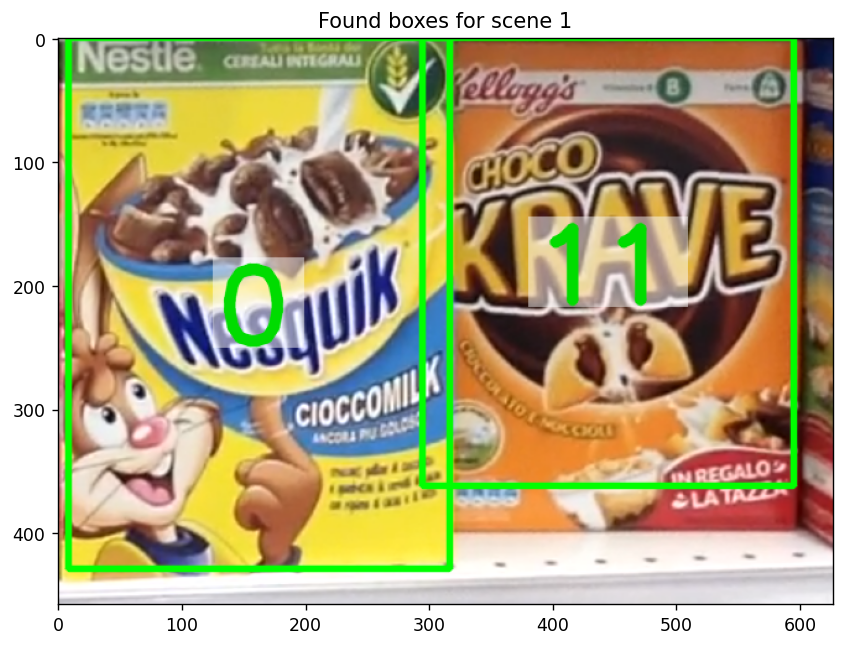

🔬 Completed analysis of scene: 1

🖼️ Analysis of scene: 2

****************************************************************************************************

Product 0 - 0 instance(s) found:
Product 1 - 0 instance(s) found:
Product 11 - 0 instance(s) found:
Product 19 - 0 instance(s) found:
Product 24 - 1 instance(s) found:
	Instance 1 {position: (167, 232), width: 334px, height: 464px}
Product 25 - 1 instance(s) found:
	Instance 1 {position: (878, 233), width: 312px, height: 442px}
Product 26 - 1 instance(s) found:
	Instance 1 {position: (538, 230), width: 332px, height: 461px}



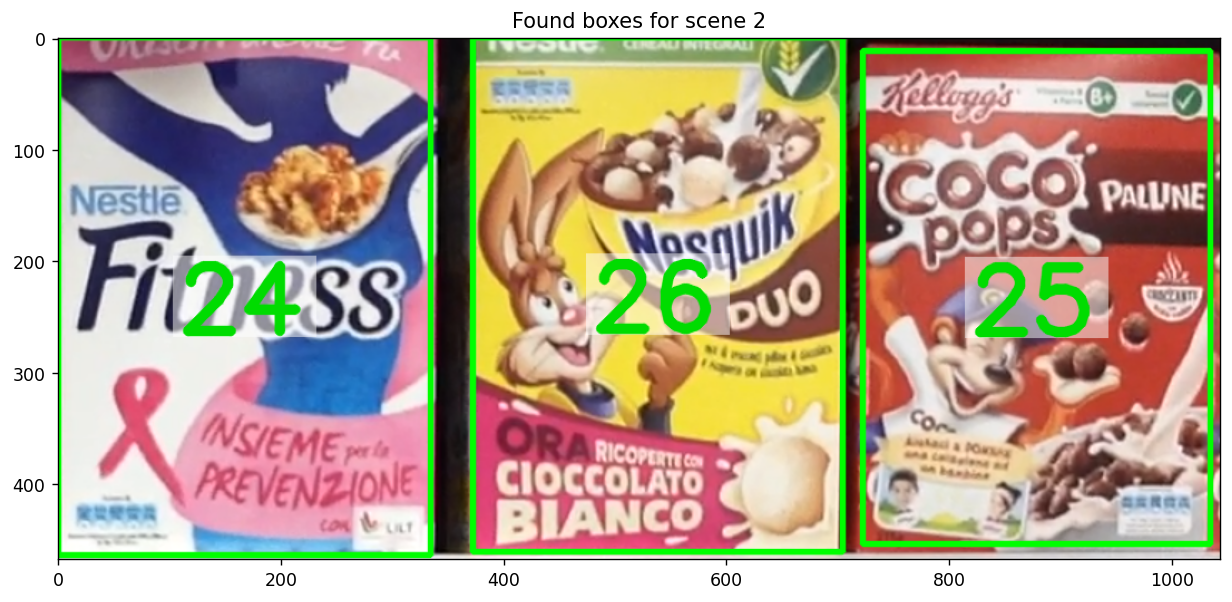

🔬 Completed analysis of scene: 2

🖼️ Analysis of scene: 3

****************************************************************************************************

Product 0 - 1 instance(s) found:
	Instance 1 {position: (171, 234), width: 324px, height: 435px}
Product 1 - 1 instance(s) found:
	Instance 1 {position: (818, 197), width: 304px, height: 394px}
Product 11 - 1 instance(s) found:
	Instance 1 {position: (475, 192), width: 304px, height: 384px}
Product 19 - 0 instance(s) found:
Product 24 - 0 instance(s) found:
Product 25 - 0 instance(s) found:
Product 26 - 0 instance(s) found:



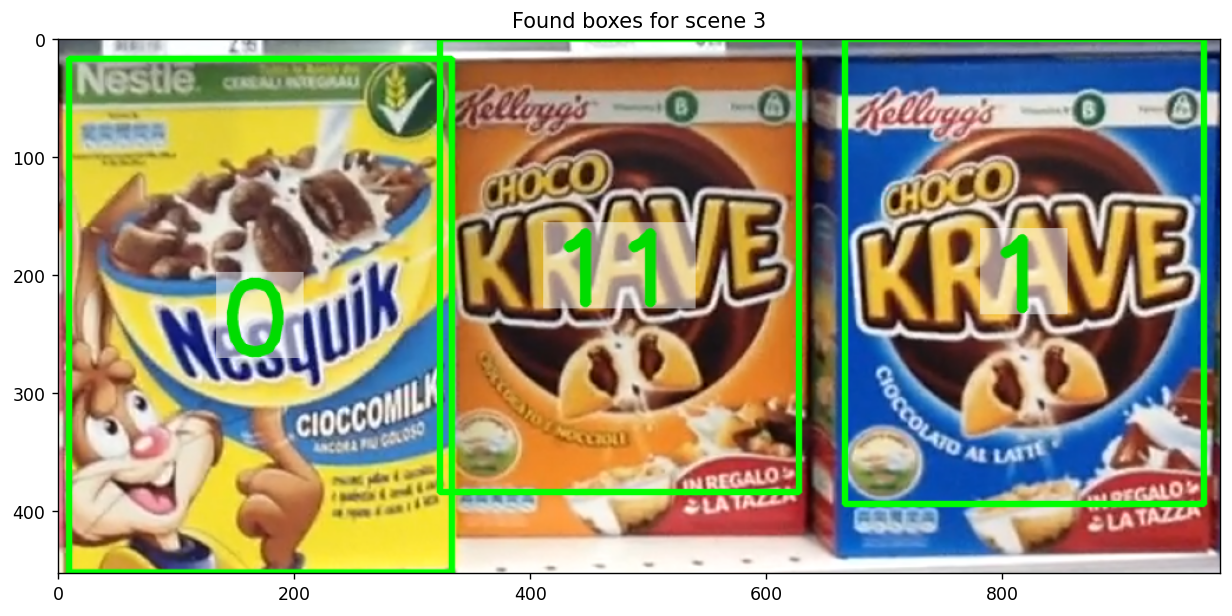

🔬 Completed analysis of scene: 3

🖼️ Analysis of scene: 4

****************************************************************************************************

Product 0 - 1 instance(s) found:
	Instance 1 {position: (160, 737), width: 320px, height: 436px}
Product 1 - 0 instance(s) found:
Product 11 - 1 instance(s) found:
	Instance 1 {position: (462, 690), width: 303px, height: 395px}
Product 19 - 0 instance(s) found:
Product 24 - 0 instance(s) found:
Product 25 - 1 instance(s) found:
	Instance 1 {position: (546, 264), width: 334px, height: 529px}
Product 26 - 1 instance(s) found:
	Instance 1 {position: (206, 221), width: 341px, height: 442px}



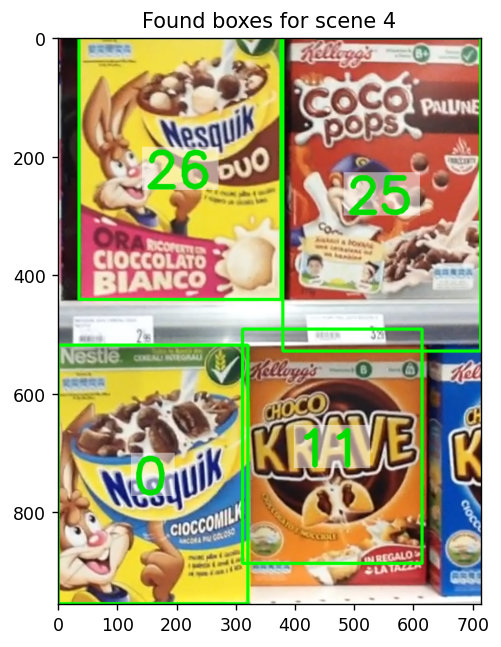

🔬 Completed analysis of scene: 4

🖼️ Analysis of scene: 5

****************************************************************************************************

Product 0 - 0 instance(s) found:
Product 1 - 0 instance(s) found:
Product 11 - 0 instance(s) found:
Product 19 - 1 instance(s) found:
	Instance 1 {position: (504, 191), width: 295px, height: 382px}
Product 24 - 0 instance(s) found:
Product 25 - 1 instance(s) found:
	Instance 1 {position: (161, 228), width: 320px, height: 444px}
Product 26 - 0 instance(s) found:



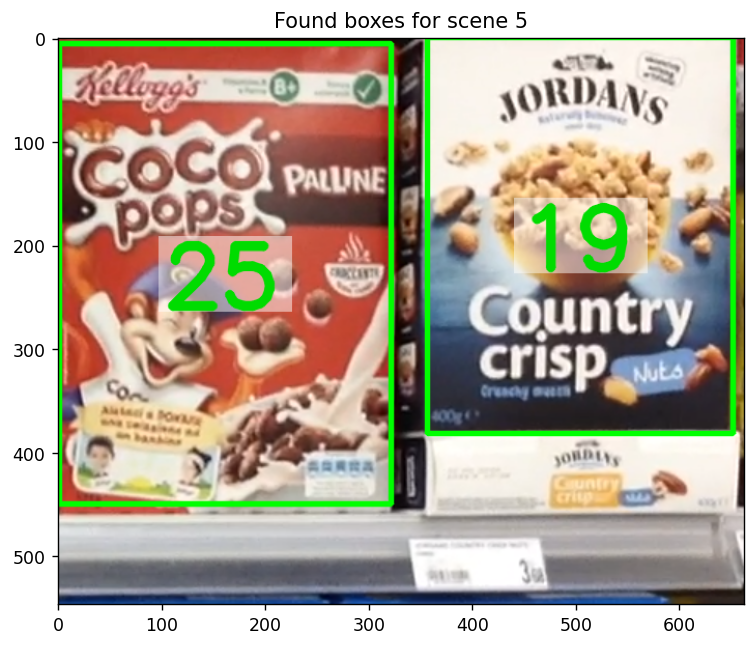

🔬 Completed analysis of scene: 5



In [212]:
main(
    min_count=160,
    query_images_grey=query_images_grey,
    train_images_rgb=train_images_rgb,
    train_images_grey=train_images_grey,
    height_threshold=1.15)

### Results summary